In [19]:
import numpy as np
import dateutil.parser as dp
import matplotlib.pyplot as plt
#plt.style.use("MC.mplstyle")
import pandas as pd

file_header_dtype = np.dtype([('file_cookie', 'S2'),
                               ('file_version', 'S2'),
                               ('file_size', 'i4'),
                               ('num_waveforms', 'i4')])

waveform_header_dtype = np.dtype([('header_size', 'i4'),
                                ('waveform_type', 'i4'),
                                ('num_waveform_buffers', 'i4'),
                                ('num_points', 'i4'),
                                ('count', 'i4'),
                                ('x_display_range', 'f4'),
                                ('x_display_origin', 'f8'),
                                ('x_increment', 'f8'),
                                ('x_origin', 'f8'),
                                ('x_units', 'i4'),
                                ('y_units', 'i4'),
                                ('date_string', 'S16'),
                                ('time_string', 'S16'),
                                ('frame_string', 'S24'),
                                ('waveform_string', 'S16'),
                                ('time_tag', 'f8'),
                                ('segment_index', 'u4')])

buffer_header_dtype = np.dtype([('header_size', 'i4'),
                                ('buffer_type', 'i2'),
                                ('bytes_per_point', 'i2'),
                                ('buffer_size', 'i4')])

def read_agilent_binary(fname, use_segments=False, include_time_vector=False, include_datetime=True):
    """Reads all the channel data from an Agilent/Infinium Oscilloscope into a dict
    indexed by scope channel number. Optionally computes the time vector, and adds that to
    the output dict also."""
    with open(fname, 'rb') as f:
        file_header = np.fromfile(f, dtype=file_header_dtype, count=1)

        wf_dict = {}

        #Agilent uses 1-indexing for their waveforms
        for wfx in np.arange(file_header['num_waveforms'][0])+1:

            #Read the waveform header
            wf_header = np.fromfile(f, dtype=waveform_header_dtype, count=1)

            #Grab important strings in a python 2/3 compatible way
            channel_string = bytes(wf_header['waveform_string'][0]).decode('utf-8').replace(' ', '_')
            date_string = bytes(wf_header['date_string'][0]).decode('utf-8')
            time_string = bytes(wf_header['time_string'][0]).decode('utf-8')


            #Start a new dictionary
            wf_dict[channel_string] = {}

            #Might need to allow for multiple segments, in which case y_data is a dict
            if use_segments:
                wf_dict[channel_string]['segment_data'] = []
                segment_index = int(wf_header['segment_index'][0])
                time_tag = wf_header['time_tag'][0]

            #Fill with metadata
            for key in wf_header.dtype.names:
                if key not in ['header_size', 'waveform_type', 'num_waveform_buffers', 'segment_index', 'time_tag']:
                    wf_dict[channel_string][key] = wf_header[key][0]

            if include_datetime:
                datetime = dp.parse(date_string + ' ' + time_string)
                wf_dict[channel_string]['datetime'] = datetime

            #Loop through all the data buffers for this waveform (usually just one)
            for bfx in range(wf_header['num_waveform_buffers'][0]):
                #Read the buffer header
                bf_header = np.fromfile(f, dtype=buffer_header_dtype, count=1)

                #Format the dtype for the array
                bf_type = bf_header['buffer_type'][0]

                if bf_type in [1,2,3]:
                    #Float
                    f_str = 'f4'
                elif bf_type == 4:
                    #Integer
                    f_str = 'i4'
                else:
                    #Boolean or other
                    f_str = 'u1'

                ch_dtype = np.dtype([('data', f_str)])

                num_points = int(bf_header['buffer_size'][0]/bf_header['bytes_per_point'][0])

                #This hstacks buffers if there are more than one. Don't know if that is right or not...
                #Maybe should be vstacking them instead? Never seen more than one anyhow.
                if bfx == 0:
                    ch_data = np.fromfile(f, dtype=ch_dtype, count=num_points)
                else:
                    ch_data = np.hstack[[ch_data, np.fromfile(f, dtype=ch_dtype, count=num_points)]]

            assert num_points == len(ch_data), "Points mismatch in buffer!"

            if use_segments:
                y_data = {}
                y_data['segment_index'] = segment_index
                y_data['time_tag'] = time_tag
                y_data['y_data'] = ch_data['data']
                wf_dict[channel_string]['segment_data'].append(y_data)
            else:
                wf_dict[channel_string]['y_data'] = ch_data['data']

            if include_time_vector:
                #Build up the time vector
                if wfx == 1:
                    tvec = wf_header['x_increment'][0]*np.arange(wf_header['num_points'][0])+wf_header['x_origin']
                    wf_dict[channel_string]['x_data'] = tvec

                assert len(tvec) == len(ch_data), "The jerk who programmed this almost certainly handled the buffers wrong!"

    return wf_dict


def filterData(data, windowSize):
    return pd.Series(data).rolling(window=windowSize).mean()

In [12]:
fname = ('1901_BEL_data/scope_81.bin')
test = read_agilent_binary(fname, use_segments=False, include_time_vector=False, include_datetime=False)



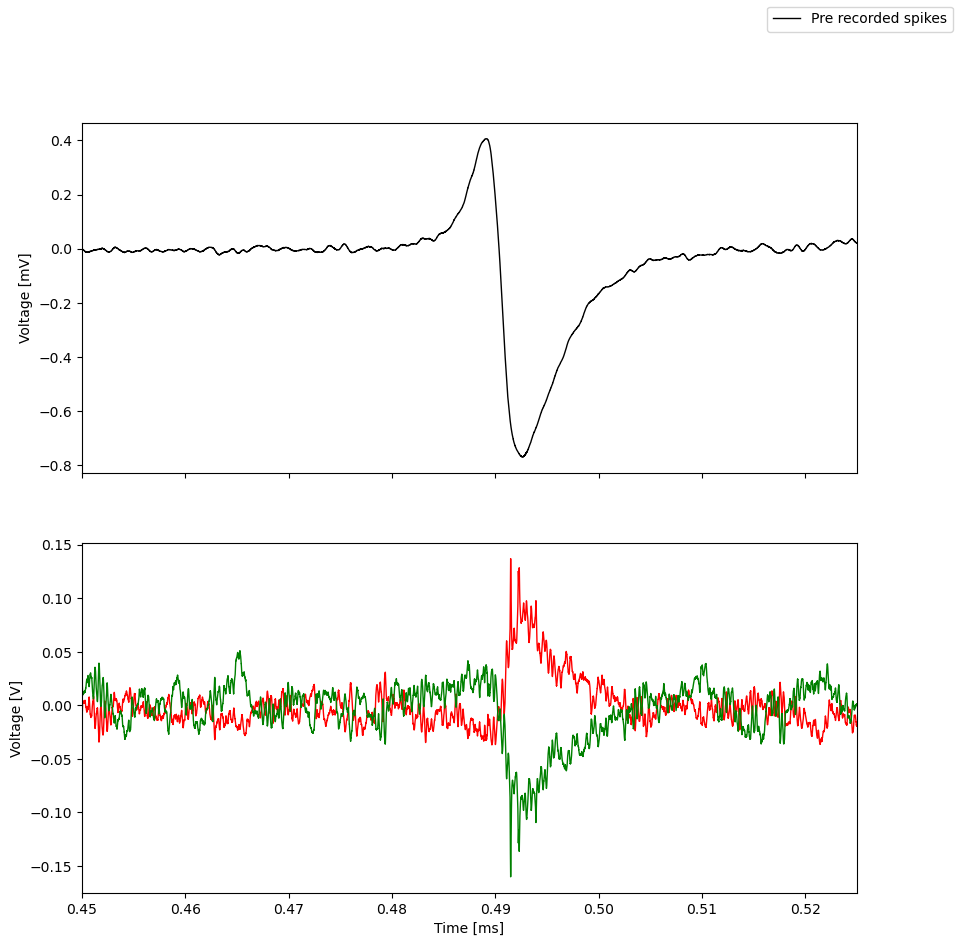

In [36]:
fig, [ax1,ax2] = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
time = np.linspace(0, 1,2000000)
data = filterData(test['1']['y_data'],1000)

ax1.plot(time,data, 'k',label = "Pre recorded spikes", linewidth=1)
ax1.set_ylabel("Voltage [mV]")


ax2.set_ylabel("Voltage [V]")

ax2.set_xlabel("Time [ms]")
data = filterData(test['3']['y_data'],100)

ax2.plot(time,data, 'r', label = "", linewidth=1)
data = filterData(test['4']['y_data'],100)

ax2.plot(time,data, 'g', label = "", linewidth=1)

ax2.set_xlim([0.45,0.525])
fig.legend()
fig.savefig("test1.svg")
#plt.plot(test['4']['y_data'])

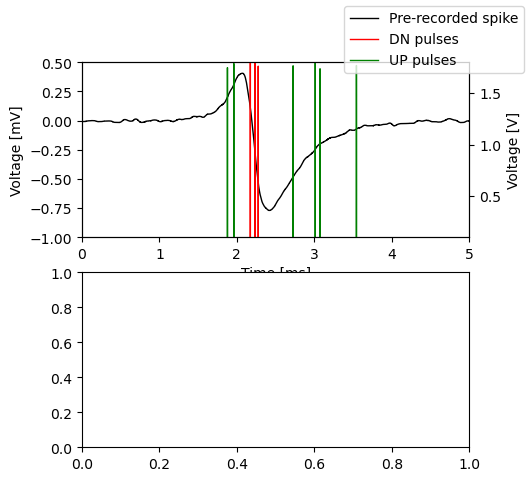

In [106]:
fname = ('1901_BEL_data/scope_75.bin')
test = read_agilent_binary(fname, use_segments=False, include_time_vector=False, include_datetime=False)


fig, [ax1,ax2] = plt.subplots(2, 1, figsize=(5, 5), sharex=False)
time = np.linspace(0, 10,test["1"]["num_points"])
data = filterData(test['1']['y_data'],10000)

ax1.plot(time-2,data, 'k',label = "Pre-recorded spike", linewidth=1)
ax4 = ax1.twinx()

ax1.set_ylabel("Voltage [mV]")


ax4.set_ylabel("Voltage [V]")

ax4.set_xlabel("Time [ms]")

data = filterData(test['2']['y_data'],100)

ax4.plot(time-2,data, 'r', label = "DN pulses", linewidth=1)
data = filterData(test['3']['y_data'],100)
ax4.plot(time-2,data*-1.8, 'g', label = "UP pulses", linewidth=1)

ax4.set_ylim([0.1,1.8])
ax1.set_xlim([0,5])
ax1.set_ylim([-1,0.5])
ax1.set_xlabel("Time [ms]")

fig.legend(prop={'size': 10})
fig.savefig("trace_CM.svg")

